In [1]:
import pyspark
import timeit
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Assignment") \
    .enableHiveSupport() \
    .getOrCreate()


ModuleNotFoundError: No module named 'pyspark'

In [ ]:
yellow_taxi_2023=spark.read.parquet("s3://ngap--fin-plng-and-perf-mgmt--prod--us-west-2/dev/raw/internal-order/changes/playbook_files/yellow_tripdata_2023-01.parquet")
yellow_taxi_2023.printSchema()



In [ ]:
taxi_lookup=spark.read.option("header",True) \
     .csv("s3://ngap--fin-plng-and-perf-mgmt--prod--us-west-2/dev/raw/internal-order/changes/playbook_files/taxi+_zone_lookup.csv")
taxi_lookup.printSchema()



In [ ]:
start=timeit.default_timer()
count_of_trips=yellow_taxi_2023.count()
end=timeit.default_timer()
elap_time_count=end-start


In [ ]:
from pyspark.sql.functions import mean
start=timeit.default_timer()
yellow_taxi_2023.select(mean ('trip_distance')).show()
end=timeit.default_timer()
elap_time_average=end-start


In [ ]:
from pyspark.sql.functions import mean,sum,avg
start=timeit.default_timer()
yellow_taxi_2023.select(sum('fare_amount')).show()
end=timeit.default_timer()
elap_time_sum=end-start


In [ ]:
from pyspark.sql.functions import  coalesce, lit, mean, sum, avg, col,SaveMode
start=timeit.default_timer()
comp_query=yellow_taxi_2023.alias("tripp").join(taxi_lookup.alias("locc"),\
                                                col("tripp.PULocationID")==col("locc.LocationID"),"inner")\
.select(col("locc.Borough").alias("borough"),
        col("locc.Zone").alias("zone"),
        col("tripp.fare_amount").alias("fare")).\
where(col("tripp.tolls_amount") !=lit(0)).groupby("borough").agg(avg("fare").\
                                                    alias("average_fare_for_toll_routes"))
end=timeit.default_timer()
elap_time_transformation=end-start
start=timeit.default_timer()
comp_query.show()
end=timeit.default_timer()
elap_time_action=end-start


In [ ]:
spark = SparkSession \
    .builder \
    .appName("Assignment") \
    .enableHiveSupport() \
    .getOrCreate()

# creation of empty datafreme for tracking time for operations
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,FloatType
schema = StructType([ \
    StructField("operation",StringType(),True), \
    StructField("spark_elapsed_time",FloatType(),True), \
    StructField("hive_elapsed_time",FloatType(),True)
  ])
data_collected = [("count",elap_time_count,15.724),
    ("average",elap_time_average,9.571),
    ("sum",elap_time_sum,8.953),
    ("comp_query",elap_time_action,18.86)
  ]
perfDf = spark.createDataFrame(data=data_collected,schema=schema)

perfDf.write\
        .option("path", "s3://ngap--fin-plng-and-perf-mgmt--prod--us-west-2/dev/raw/internal-order/changes/playbook_files/hive_ext_table")\
        .saveAsTable("perf_difference")
spark.sql("select * from perf_difference").show()

In [ ]:
#creating hive table from dataframe
yellow_taxi_2023.write\
        .option("path", "s3://ngap--fin-plng-and-perf-mgmt--prod--us-west-2/dev/raw/internal-order/changes/playbook_files/taxi_trips")\
        .saveAsTable("yellow_taxi_tripss")
spark.sql("select * from yellow_taxi_tripss").show()
taxi_lookup.write\
        .option("path", "s3://ngap--fin-plng-and-perf-mgmt--prod--us-west-2/dev/raw/internal-order/changes/playbook_files/taxi_lookup")\
        .saveAsTable("taxilookupp")
spark.sql("select * from taxilookupp").show()

            spark_elapsed_time  hive_elapsed_time
count                 2.854264             18.860
average               2.491249              9.571
sum                   6.933339             15.724
comp_query            1.332717              8.953


<AxesSubplot:>

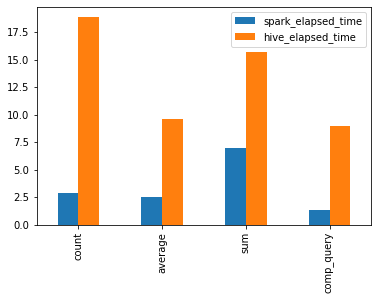

In [10]:
import matplotlib.pyplot
import pandas as pd

df = pd.DataFrame({'spark_elapsed_time': [2.8542643, 2.4912488, 6.9333386,1.3327171],
                   'hive_elapsed_time': [18.86, 9.571, 15.724,8.953]},
                  index=['count', 'average', 'sum','comp_query'])
  
print(df)
df.plot.bar()